# Experiment 1
Input data: DAiSEE features extracted using OpenFace2.0 in CSV files
(Step 0) Data preparation:
* [Case 1] Average all frames into 1 timesteps
* [Case 2] Average every 30 frames, resulting on 10 timesteps, export dataset in pickle

Step 1: Load data and preprocess (for case 1)

Step 2: Build models, compile, and train. 

Step 3: Evaluation

* Performance comparation between LSTM, CNN, and Classical Machine Learning Model

Check EDA repository to understand how the data were extracted and prepared 
https://github.com/shofi777/EDA.git

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential #, Input
from tensorflow.keras.layers import *
# from keras.layers import Attention
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, auc, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline
# %matplotlib notebook

# 1. Load Data and Pre-process

In [2]:
#load data
def load_data(datafile):
    df = pd.read_csv(datafile)
    df = df.drop(df.columns[0], axis=1)
    return df

#Split features and label
def split_label(df):
    df = np.array(df)
    Y = df[:,-1]
    print('Y original =', Y)
    Y = np.where(Y==1, 0, Y) #combine label 0 and 1
    Y = np.where(Y==2, 1, Y) #change label 2 to 1
    Y = np.where(Y==3, 2, Y) #change label 3 to 2
    print('Y before encode =', Y)
    Y = LabelEncoder().fit_transform(Y) #encode label value as label variable
    print('Y after encode =', Y)
    X = df[:,0:-1]    
    return X, Y

#Resampling
def resample(label0,label1,label2,X,Y):
    #downsampling
    strategydown = {0:label0, 1:label1, 2:label2} 
    downsample = RandomUnderSampler(sampling_strategy=strategydown) 
    X_resampled, Y_resampled = downsample.fit_resample(X, Y) #fit and apply transform
    
    #oversampling
    oversample = SMOTE()#sampling_strategy='not minority'
    X_resampled, Y_resampled = oversample.fit_resample(X_resampled, Y_resampled) #fit and apply transform
    return X_resampled, Y_resampled 

# Normalization and dimensionality reduction
def norm(X):     
    # normalize the range features
    scaler = MinMaxScaler(feature_range=(0,1))  #.fit(X_train_av)
    X = scaler.fit_transform(X)

    # PCA decomposition. Set components number from 329(original) to 200 (to 1500 for daisee_mediapipe data)
    pca = decomposition.PCA(n_components=200) #.fit(X_train_av)
    X = pca.fit_transform(X)
    
    return X #, X_inverted

#reshape to 3D data (nsample,ntimestep,nfeatures)
def reshaping(X):
    X = X.reshape(X.shape[0],1,X.shape[1]) 
    return X

## [Case 1] Averaged data input

In [3]:
df_train_av = load_data('dataset/average_train.csv')
df_val_av = load_data('dataset/average_val.csv')
df_test_av = load_data('dataset/average_test.csv')
print('Train = ', df_train_av.shape)
print('Val = ', df_val_av.shape)
print('Test = ', df_test_av.shape)

Train =  (5358, 330)
Val =  (1429, 330)
Test =  (1784, 330)


In [4]:
#Concatenate train and validation set
df_train_concat = pd.concat([df_train_av,df_val_av], axis=0, ignore_index=True)
df_all_concat = pd.concat([df_train_concat,df_test_av], axis=0, ignore_index=True)
print(df_all_concat.shape)
print(df_train_concat.shape)

(8571, 330)
(6787, 330)


In [5]:
X_train_all, Y_train_all = split_label(df_all_concat)
X_train_av, Y_train_av = split_label(df_train_concat)
# X_train_av, Y_train_av = split_label(df_train_av)
X_val_av, Y_val_av = split_label(df_val_av)
X_test_av, Y_test_av = split_label(df_test_av)

Y original = [2. 2. 3. ... 3. 3. 2.]
Y before encode = [1. 1. 2. ... 2. 2. 1.]
Y after encode = [1 1 2 ... 2 2 1]
Y original = [2. 2. 3. ... 2. 2. 2.]
Y before encode = [1. 1. 2. ... 1. 1. 1.]
Y after encode = [1 1 2 ... 1 1 1]
Y original = [2. 3. 2. ... 2. 2. 2.]
Y before encode = [1. 2. 1. ... 1. 1. 1.]
Y after encode = [1 2 1 ... 1 1 1]
Y original = [2. 2. 2. ... 3. 3. 2.]
Y before encode = [1. 1. 1. ... 2. 2. 1.]
Y after encode = [1 1 1 ... 2 2 1]


Train + Validation set:
Engagement=1, n=3430 (50.538%)
Engagement=2, n=2944 (43.377%)
Engagement=0, n=413 (6.085%)
Total= 6787

Validation-only set:
Engagement=1, n=813 (56.893%)
Engagement=2, n=450 (31.491%)
Engagement=0, n=166 (11.617%)
Total= 1429

Test set:
Engagement=1, n=882 (49.439%)
Engagement=2, n=814 (45.628%)
Engagement=0, n=88 (4.933%)
Total= 1784
[1, 2, 0]
[3430, 2944, 413]


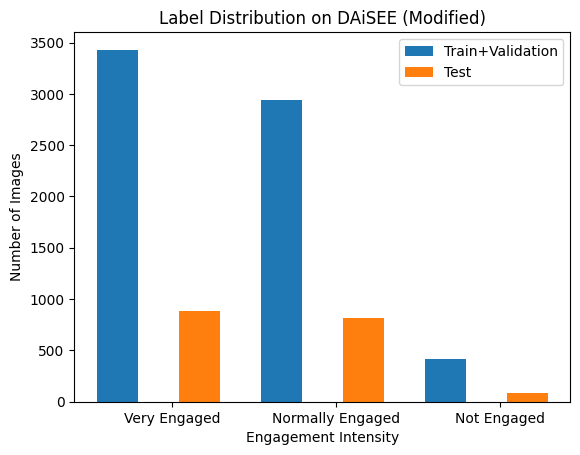

In [6]:
#Plot Distribution after concatenation train+validation
def plot_dist(Y):
    counter = Counter(Y)
    key =[]
    value = []
    for k,v in counter.items():
        per = v / len(Y)*100
        print('Engagement=%d, n=%d (%.3f%%)' % (k,v,per))
        key.append(k)
        value.append(v)
    print('Total=', len(Y))
    return key, value

print("Train + Validation set:")
k_train, v_train = plot_dist(Y_train_av)
print("\nValidation-only set:")
k_val, v_val = plot_dist(Y_val_av)
print("\nTest set:")
k_test, v_test = plot_dist(Y_test_av)
print(k_train)
print(v_train)

#Plot the distribution
ind = np.arange(len(k_train)) 
w = 0.25 
plt.bar(ind  , v_train, width=w, label='Train+Validation')
# plt.bar(ind + w, v_val, width=w, label='Validation')
plt.bar(ind + w + w, v_test, width=w,label='Test')

plt.ylabel('Number of Images')
plt.xlabel('Engagement Intensity')
plt.title('Label Distribution on DAiSEE (Modified)')
plt.xticks(ind + w + w/ 3, ('Very Engaged','Normally Engaged','Not Engaged'))

# plt.title('Engagement Label Distributions on DAiSEE')
# plt.xticks(ind + 0.08 + 0.08 + 0.08, ('3\nVery High','2\nHigh','1\nLow','0\nVery Low'))
plt.legend(loc='best')
plt.show()

In [7]:
X_train_all, Y_train_all = resample(501,2000,2000,X_train_all,Y_train_all) #413,1472,1715
X_train_av, Y_train_av = resample(413,1000,1000,X_train_av,Y_train_av) #247,1000,1000
X_val_av, Y_val_av = resample(166,200,200,X_val_av,Y_val_av)
X_test_av, Y_test_av = resample(88,441,407,X_test_av,Y_test_av)

In [8]:
X_train_all_norm = norm(X_train_all)
X_train = norm(X_train_av)
X_val_av_norm = norm(X_val_av)
X_test_av_norm = norm(X_test_av)
# print('X training=',X_train.shape)
# # print('X val=',X_val.shape)
# print('X test=',X_test.shape)
X_train_av = X_train

In [9]:
X_train_all = reshaping(X_train_all_norm)
X_train_av = reshaping(X_train_av)
X_val_av = reshaping(X_val_av_norm)
X_test_av = reshaping(X_test_av_norm) 
print('X_train_all:{} | Y_train_all:{}\nX_train_av:{} | Y_train_av:{}\nX_test_av:{} | Y_test_av:{} '.format(X_train_all.shape, Y_train_all.shape, X_train_av.shape, Y_train_av.shape, X_test_av.shape, Y_test_av.shape))

X_train_all:(6000, 1, 200) | Y_train_all:(6000,)
X_train_av:(3000, 1, 200) | Y_train_av:(3000,)
X_test_av:(1323, 1, 200) | Y_test_av:(1323,) 


In [10]:
Y_train_cat_all = to_categorical(Y_train_all)
Y_train_cat_av = to_categorical(Y_train_av) #convert label vector to one-hot matrix
Y_val_cat_av = to_categorical(Y_val_av) #convert label vector to one-hot matrix
Y_test_cat_av = to_categorical(Y_test_av) 
print('Y after convert to 1hot =', Y_train_cat_av)
print(Y_train_cat_av.shape)

Y after convert to 1hot = [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(3000, 3)


# 2. Build Models, Compile and Train

In [11]:
# CNN
def CNN(X):
    # Initialising the CNN
    model = Sequential()

    ## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
    # 1 - Convolution
    model.add(Conv1D(64,3, padding='same', input_shape=((X.shape[1],X.shape[2]))))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(MaxPooling1D(pool_size=2)) #downsampling/ shrink the height and width dimension by factor of 2  
   
    # 2nd Convolution layer
    model.add(Conv1D(128,5, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))

    # 3rd Convolution layer
    model.add(Conv1D(512,3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))

    # 4th Convolution layer
    model.add(Conv1D(512,3, padding='same'))#
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    # Fully connected layer 3nd layer
    model.add(Dense(512, name = 'convy'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(3, activation='softmax'))

    model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001)
    model._name='CNNmodel'
    model.summary()

    return model

In [12]:
# LSTM
# ## 1. Vanila LSTM
# - Memory cells of a single LSTM layer are used in a simple network structure
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1],X.shape[2]))) #use average data
    model.add(Dense(3, activation='softmax'))
    model._name='vanilaLSTM'
    print(model.summary())
    return model

# ## 2. Stacked LSTM
# - LSTM layers are stacked one on top of another into deep recurrent neural networks
def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='stackedLSTM'
    print(model.summary())
    return model

# ## 3. Bi-LSTM
# - Input sequences are presented and learned both forward and backward
def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM'
    print(model.summary())
    return model

# ## 4. BiLSTM (Ensamble)
# - Follow An Ensemble model using face and body tracking for engagement detection
def bilstm_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    # model.add(Dropout(0.5))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='bilstm_en'
    print(model.summary())
    return model

In [13]:
# CNN
CNN_model = CNN(X_train_av)

#instantiate the model[Case 1]
vanilaLSTM_model = vanilaLSTM(X_train_av)
stackedLSTM_model = stackedLSTM(X_train_av)
biLSTM_model = biLSTM(X_train_av)
bilstm_en_model = bilstm_en(X_train_av)

Model: "CNNmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             38464     
                                                                 
 batch_normalization (BatchN  (None, 1, 64)            256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 activation_1 (Activation)   (None, 1, 128)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 128)           512       
 hNormalization)                                          

In [14]:
# #instantiate the model [Case 2]
# vanilaLSTM_model = vanilaLSTM(X_train)
# stackedLSTM_model = stackedLSTM(X_train)
# biLSTM_model = biLSTM(X_train)
# bilstm_en_model = bilstm_en(X_train)

### Fit Models and Evaluation

In [15]:
#compile and train model
def compile_train(model,Xtrain,YtrainCat):
    loss = 'categorical_crossentropy' # mse 'sparse_categorical_crossentropy'
    metrics = ['categorical_accuracy'] 
    monitor= 'val_loss' 
    lr=1e-3

    #learning rate schedule: reduce learning rate 0.1 every 2 epochs 
    reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=2, min_lr=0.00001, mode='auto')
    es = EarlyStopping(monitor=monitor, min_delta=0.0001, patience=50)

    model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=metrics)  
    filepath = 'weights/' + model.name + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    history = model.fit(Xtrain,YtrainCat, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],# ,reduce_lr
                        batch_size = 32,
                        validation_split=0.2, 
                        # validation_data=(X_test_av, Y_test_cat_av), 
                        # validation_data=(X_val_av, Y_val_cat_av), 
                        shuffle=True
                        # class_weight = 'balanced'
                       )
    
    weight_file = model.save(filepath)
    # mse, acc = model.evaluate(X_train, YtrainCat, verbose=0)
    return history, weight_file

def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='macro')
    fbeta = fbeta_score(Ytest, pred, average='macro', beta=4)
    auc = roc_auc_score(Ytest, trainedmodel.predict(Xtest), average='macro', multi_class='ovr')
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error,
        '\n MSE = ',mse,
        '\n Accuracy = ',acc,
        '\n AUC = ', auc,
        '\n F1-score = ',f1,
        '\n Fbeta = ',fbeta
        )

    #  Plotting confusion matrix
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    cm = pd.DataFrame(cm,range(3),range(3))

    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    return 

#### Logistic Regression

In [16]:
# Fit multiclass Logistic Regression model
tic = datetime.now()

lr = LogisticRegression(C=1, multi_class='multinomial', max_iter=1000).fit(X_train, Y_train_av)
time = datetime.now() - tic

print("Training time single training:{}".format(time))

print("Training set score: %f" % lr.score(X_train,Y_train_av))
print("Test set score: %f" % lr.score(X_test_av_norm, Y_test_av))
print("Coefficients shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

# Kfold cross validation
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
tic = datetime.now()
n_scores = cross_val_score(lr, X_train_all_norm, Y_train_all,scoring='accuracy', cv=skf, n_jobs=1)
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Training time single training:0:00:00.085997
Training set score: 0.537667
Test set score: 0.370370
Coefficients shape:  (3, 200)
Intercept shape:  (3,)
Training time for 5-fold cv:0:00:00.589000
Mean Accuracy 5-fold cv: 0.502 (0.007)


#### CNN

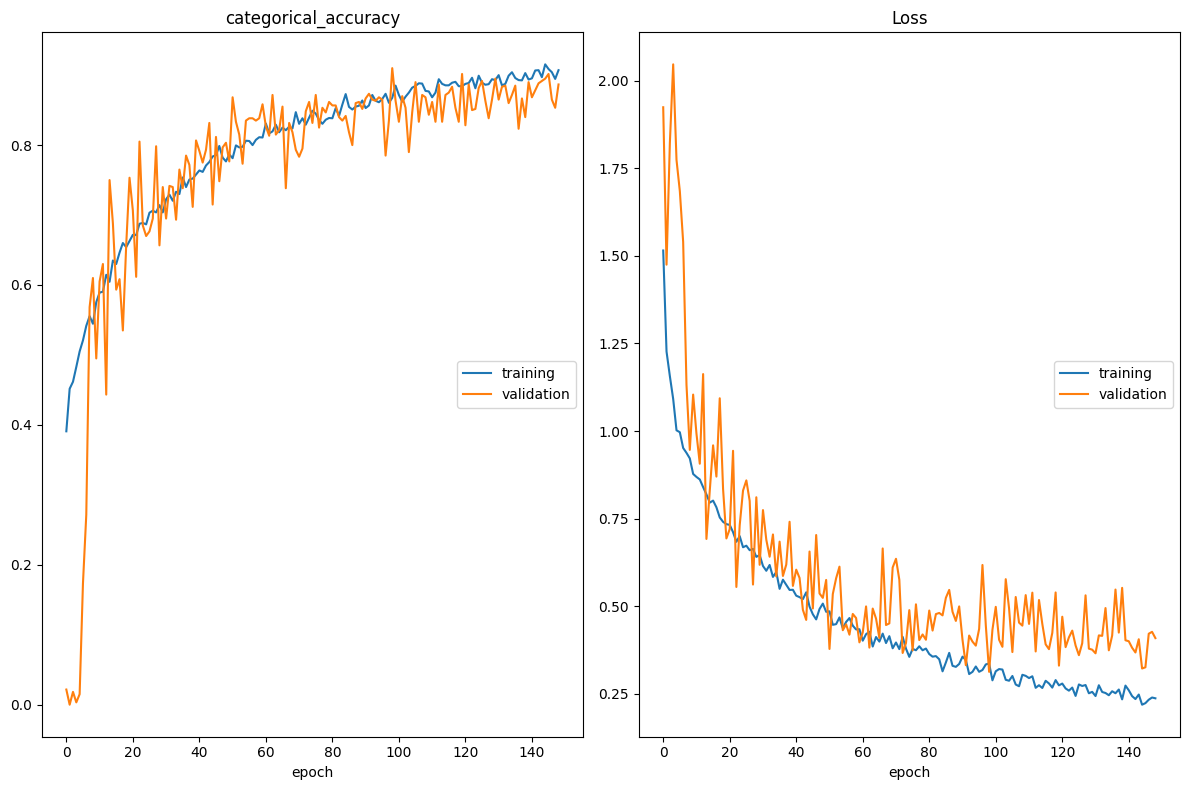

categorical_accuracy
	training         	 (min:    0.391, max:    0.915, cur:    0.907)
	validation       	 (min:    0.000, max:    0.910, cur:    0.887)
Loss
	training         	 (min:    0.218, max:    1.515, cur:    0.237)
	validation       	 (min:    0.312, max:    2.047, cur:    0.409)

Epoch 149: val_loss did not improve from 0.31228
75/75 [==============================] - 1s 9ms/step - loss: 0.2367 - categorical_accuracy: 0.9071 - val_loss: 0.4086 - val_categorical_accuracy: 0.8867
Training time:0:01:47.463378
42/42 [==============================] - 0s 3ms/step - loss: 3.8291 - categorical_accuracy: 0.3522
Accuracy on Test set: 35.22%
42/42 [==============================] - 0s 2ms/step
|CNNmodel|
 Error rate = 0.6477702191987906 
 MSE =  1.1942554799697658 
 Accuracy =  0.35222978080120937 
 AUC =  0.5105434464035047 
 F1-score =  0.3522400399094223 
 Fbeta =  0.35177719206563474
None


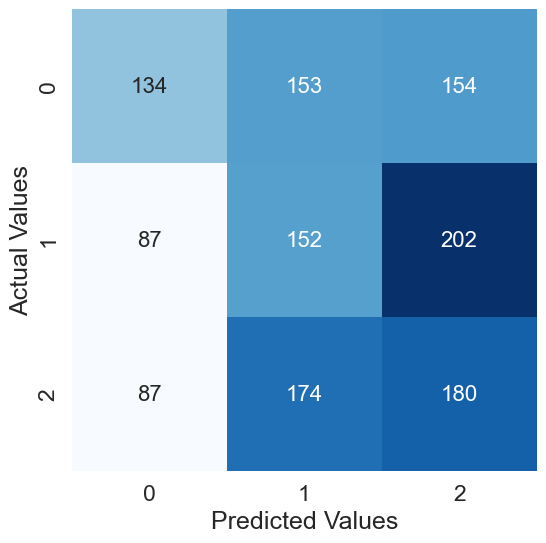

In [17]:
tic = datetime.now()
compile_train(CNN_model,X_train_av,Y_train_cat_av)  # [case 1] classification
# compile_train(vanilaLSTM_model,X_train_av,Y_train_av)  # [case 1] regression
# compile_train(vanilaLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = CNN_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(CNN_model,X_test_av, Y_test_av))


#### SingleLSTM

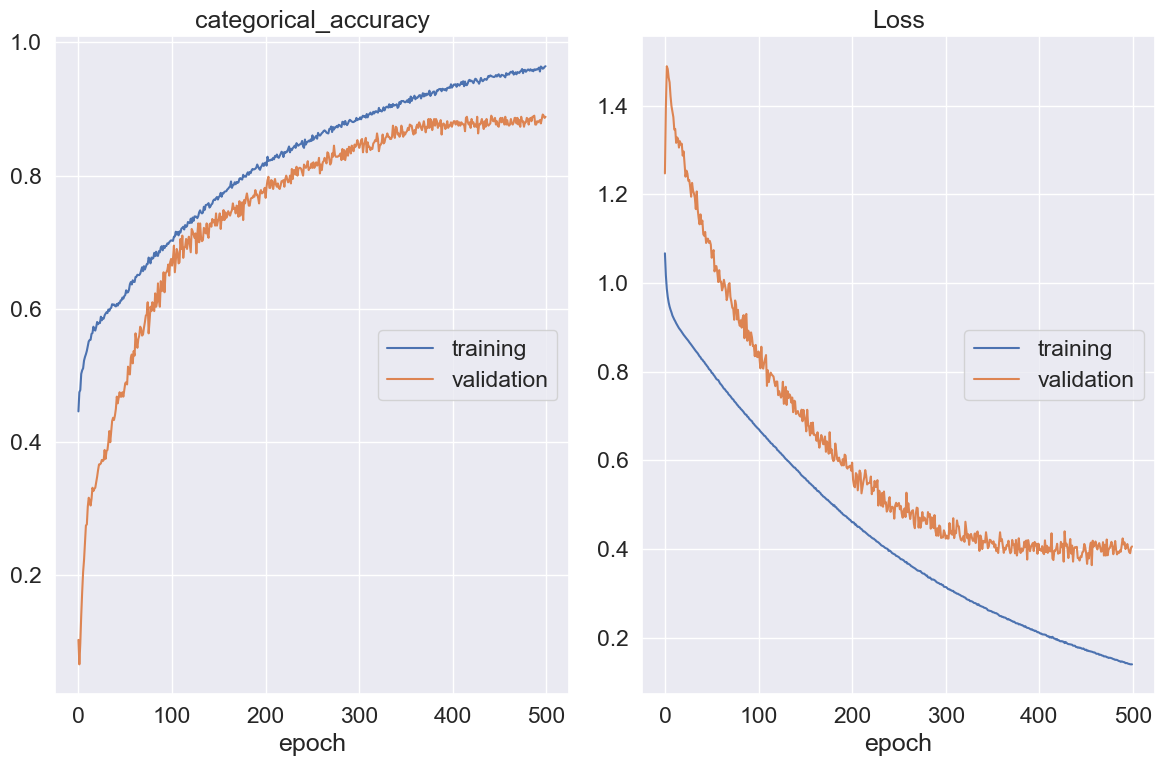

categorical_accuracy
	training         	 (min:    0.446, max:    0.964, cur:    0.964)
	validation       	 (min:    0.067, max:    0.892, cur:    0.888)
Loss
	training         	 (min:    0.140, max:    1.067, cur:    0.140)
	validation       	 (min:    0.364, max:    1.489, cur:    0.406)

Epoch 500: val_loss did not improve from 0.36356
75/75 [==============================] - 0s 7ms/step - loss: 0.1399 - categorical_accuracy: 0.9642 - val_loss: 0.4057 - val_categorical_accuracy: 0.8883
Training time:0:04:01.413448
42/42 [==============================] - 0s 2ms/step - loss: 4.2283 - categorical_accuracy: 0.3409
Accuracy on Test set: 34.09%
42/42 [==============================] - 0s 1ms/step
|vanilaLSTM|
 Error rate = 0.6591080876795162 
 MSE =  1.2078609221466365 
 Accuracy =  0.34089191232048377 
 AUC =  0.5165628861773987 
 F1-score =  0.3406227392660943 
 Fbeta =  0.3405655331796183
None


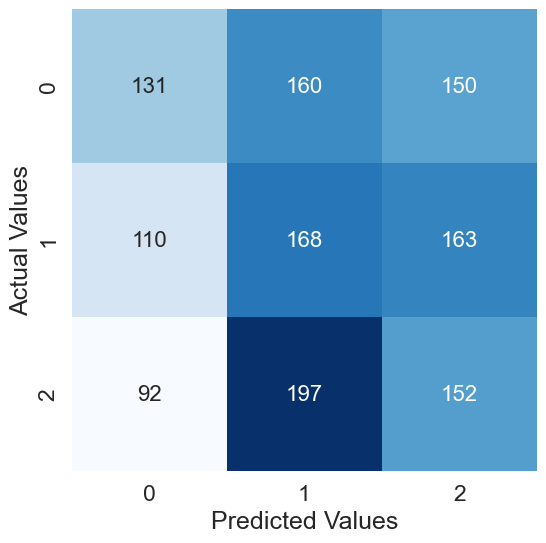

In [18]:
tic = datetime.now()
compile_train(vanilaLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] classification
# compile_train(vanilaLSTM_model,X_train_av,Y_train_av)  # [case 1] regression
# compile_train(vanilaLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model,X_test_av, Y_test_av))

#### StackedLSTM

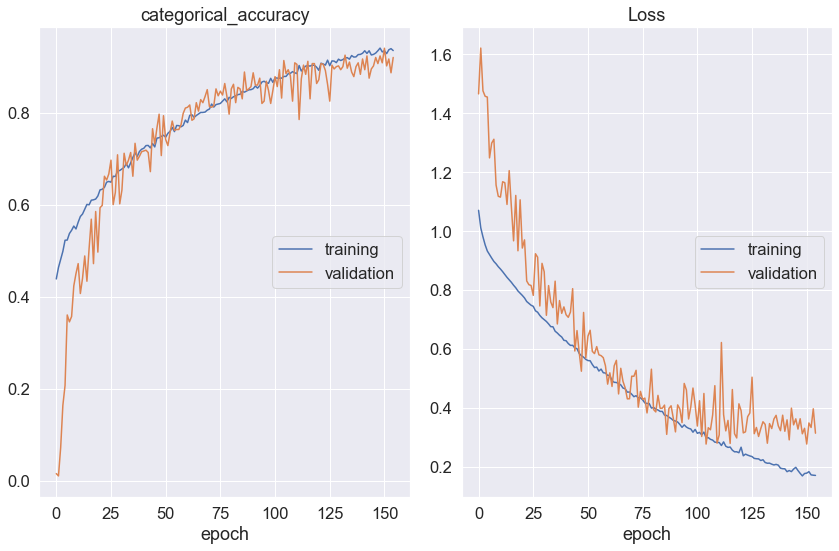

categorical_accuracy
	training         	 (min:    0.438, max:    0.940, cur:    0.935)
	validation       	 (min:    0.010, max:    0.940, cur:    0.920)
Loss
	training         	 (min:    0.168, max:    1.070, cur:    0.170)
	validation       	 (min:    0.276, max:    1.622, cur:    0.313)

Epoch 00155: val_loss did not improve from 0.27622
2400/2400 [==============================] - 0s 202us/sample - loss: 0.1697 - categorical_accuracy: 0.9350 - val_loss: 0.3132 - val_categorical_accuracy: 0.9200
Training time:0:01:19.867140
1323/1323 [==============================] - 0s 51us/sample - loss: 7.4144 - categorical_accuracy: 0.3485
Accuracy on Test set: 34.85%
|stackedLSTM|
 Error rate = 0.6515495086923658 
 MSE =  1.2932728647014362 
 Accuracy =  0.34845049130763417 
 AUC =  0.5164334819339679 
 F1-score =  0.3484449479539184 
 Fbeta =  0.3484490801842129
None


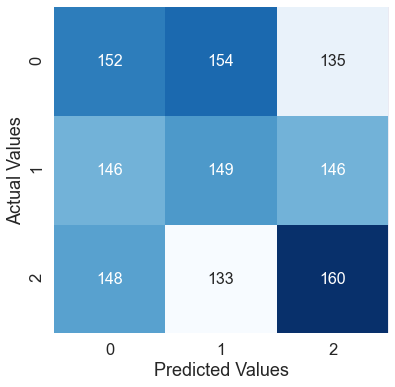

In [18]:
tic = datetime.now()
compile_train(stackedLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(stackedLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(stackedLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model,X_test_av, Y_test_av))

#### BiLSTM

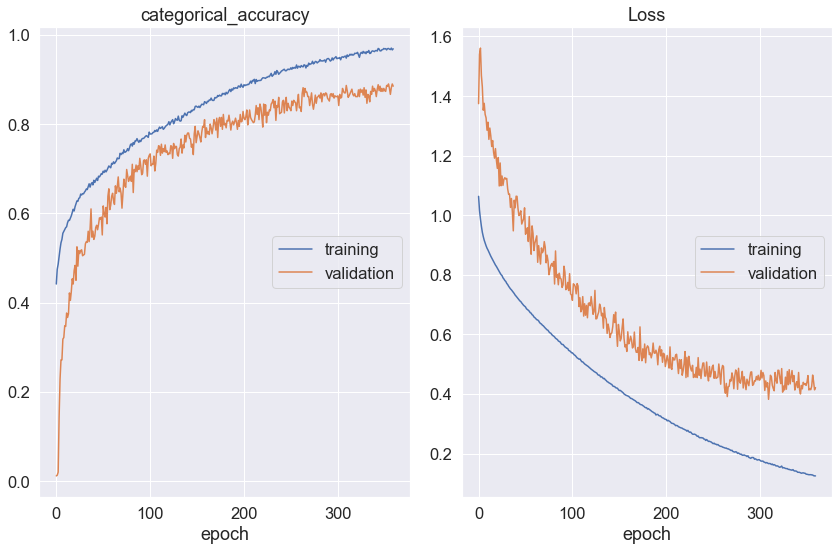

categorical_accuracy
	training         	 (min:    0.442, max:    0.970, cur:    0.969)
	validation       	 (min:    0.012, max:    0.890, cur:    0.885)
Loss
	training         	 (min:    0.125, max:    1.063, cur:    0.125)
	validation       	 (min:    0.382, max:    1.561, cur:    0.421)

Epoch 00360: val_loss did not improve from 0.38190
2400/2400 [==============================] - 0s 195us/sample - loss: 0.1249 - categorical_accuracy: 0.9688 - val_loss: 0.4214 - val_categorical_accuracy: 0.8850
Training time:0:03:01.903258
1323/1323 [==============================] - 0s 55us/sample - loss: 4.8321 - categorical_accuracy: 0.3568
Accuracy on Test set: 35.68%
|biLSTM|
 Error rate = 0.6432350718065004 
 MSE =  1.1534391534391535 
 Accuracy =  0.35676492819349964 
 AUC =  0.5265342972663997 
 F1-score =  0.35514480646059593 
 Fbeta =  0.35617388210743856
None


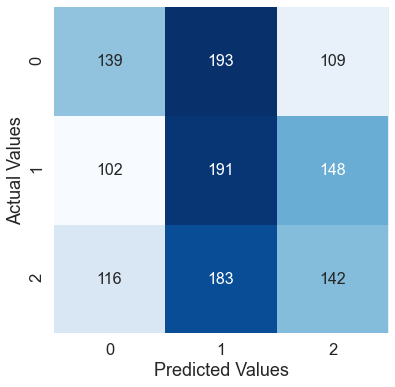

In [19]:
tic = datetime.now()
compile_train(biLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(biLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(biLSTM_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model,X_test_av, Y_test_av))

#### Multilayer-BiLSTM

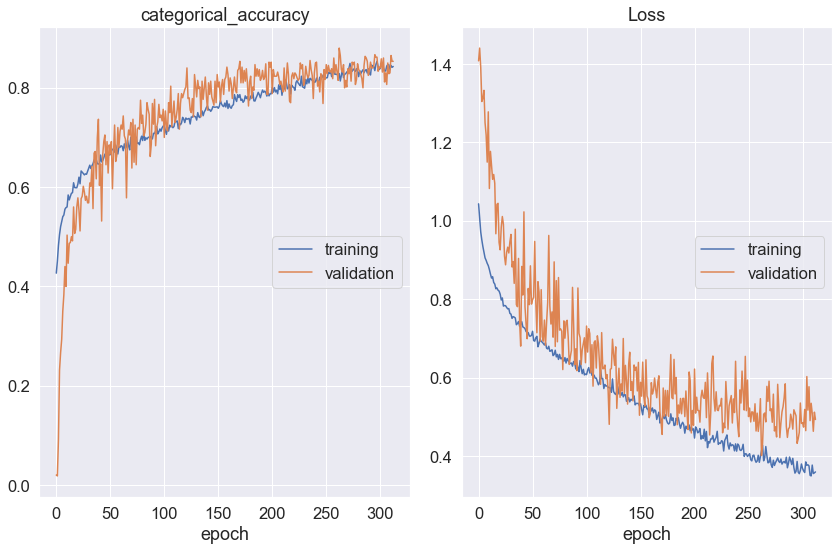

categorical_accuracy
	training         	 (min:    0.427, max:    0.853, cur:    0.843)
	validation       	 (min:    0.018, max:    0.880, cur:    0.853)
Loss
	training         	 (min:    0.349, max:    1.043, cur:    0.360)
	validation       	 (min:    0.401, max:    1.441, cur:    0.493)

Epoch 00313: val_loss did not improve from 0.40138
2400/2400 [==============================] - 1s 238us/sample - loss: 0.3595 - categorical_accuracy: 0.8429 - val_loss: 0.4932 - val_categorical_accuracy: 0.8533
Training time:0:03:01.604953
1323/1323 [==============================] - 0s 76us/sample - loss: 3.6546 - categorical_accuracy: 0.3500
Accuracy on Test set: 35.00%
|bilstm_en|
 Error rate = 0.6500377928949358 
 MSE =  1.2123960695389266 
 Accuracy =  0.34996220710506426 
 AUC =  0.5081794622610949 
 F1-score =  0.34391604438873163 
 Fbeta =  0.34845627662677253
None


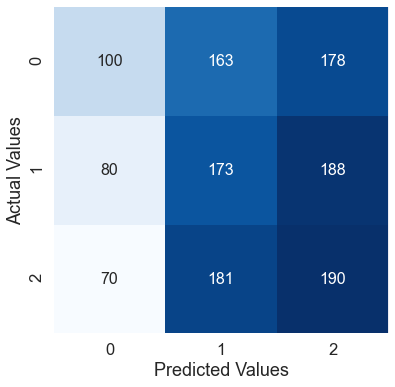

In [21]:
tic = datetime.now()
compile_train(bilstm_en_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(bilstm_en_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(bilstm_en_model,X_train,Y_train_cat)  # [case 2]
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = bilstm_en_model.evaluate(X_test_av, Y_test_cat_av)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(bilstm_en_model,X_test_av, Y_test_av))

## K-Fold Cross Validation

In [22]:
save_dir = '/weights/'
fold_var = 1
#KFold split
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
cvscores_single = []


#### CNN

In [23]:
cvscores = []
tic = datetime.now()
# for train_index, val_index in enumerate(kf.split(X_train_av,Y_train_cat_av)):
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    # print("TRAIN:", train_index, "TEST:", val_index)
    # X_train, X_test = X_train_all[train_index], X_train_all[val_index]
    # Y_train, Y_test = Y_train_all[train_index], Y_train_all[val_index]
     
    CNN_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'

    CNN_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = CNN_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    # print("%s: %f" % (CNN_model.metrics_names[0], scores[0]), "%s: %.2f%%" % (CNN_model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
    
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

1200/1200 - 0s - loss: 1.4760 - categorical_accuracy: 0.6608
1200/1200 - 0s - loss: 0.7800 - categorical_accuracy: 0.7750
1200/1200 - 0s - loss: 0.4954 - categorical_accuracy: 0.8400
1200/1200 - 0s - loss: 0.3445 - categorical_accuracy: 0.9067
1200/1200 - 0s - loss: 0.2538 - categorical_accuracy: 0.9292
Training time for 5-fold cv:0:09:09.319063
Mean Accuracy 5-fold cv: 0.822 (0.097)


#### SingleLSTM

In [24]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    vanilaLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])
    vanilaLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = vanilaLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

1200/1200 - 0s - loss: 1.1045 - categorical_accuracy: 0.6058
1200/1200 - 0s - loss: 0.7423 - categorical_accuracy: 0.7308
1200/1200 - 0s - loss: 0.5424 - categorical_accuracy: 0.8008
1200/1200 - 0s - loss: 0.3628 - categorical_accuracy: 0.8742
1200/1200 - 0s - loss: 0.2990 - categorical_accuracy: 0.8808
Training time for 5-fold cv:0:03:41.633652
Mean Accuracy 5-fold cv: 0.779 (0.102)


#### StackedLSTM

In [25]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    stackedLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'
    stackedLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = stackedLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

1200/1200 - 0s - loss: 2.9391 - categorical_accuracy: 0.6042
1200/1200 - 0s - loss: 1.2072 - categorical_accuracy: 0.7733
1200/1200 - 0s - loss: 0.5614 - categorical_accuracy: 0.8517
1200/1200 - 0s - loss: 0.2894 - categorical_accuracy: 0.9233
1200/1200 - 0s - loss: 0.1743 - categorical_accuracy: 0.9450
Training time for 5-fold cv:0:05:21.066104
Mean Accuracy 5-fold cv: 0.820 (0.123)


#### Bi-LSTM

In [26]:
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    
    biLSTM_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])
    biLSTM_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = biLSTM_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])

time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))


1200/1200 - 0s - loss: 1.2307 - categorical_accuracy: 0.6417
1200/1200 - 0s - loss: 0.7579 - categorical_accuracy: 0.7517
1200/1200 - 0s - loss: 0.4431 - categorical_accuracy: 0.8450
1200/1200 - 0s - loss: 0.2430 - categorical_accuracy: 0.9042
1200/1200 - 0s - loss: 0.2762 - categorical_accuracy: 0.9150
Training time for 5-fold cv:0:05:31.486366
Mean Accuracy 5-fold cv: 0.811 (0.103)


#### Multilayer-BiLSTM

In [27]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
cvscores = []
tic = datetime.now()
for train_index, val_index in skf.split(X_train_all,Y_train_all):
    bilstm_en_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])

    bilstm_en_model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = bilstm_en_model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=2)
    cvscores.append(scores[1])
    
time = datetime.now() - tic
print("Training time for 5-fold cv:{}".format(time))
print('Mean Accuracy 5-fold cv: %.3f (%.3f)' % (np.mean(cvscores), np.std(cvscores)))

1200/1200 - 0s - loss: 1.0534 - categorical_accuracy: 0.6392
1200/1200 - 0s - loss: 0.7688 - categorical_accuracy: 0.6975
1200/1200 - 0s - loss: 0.5444 - categorical_accuracy: 0.7850
1200/1200 - 0s - loss: 0.4653 - categorical_accuracy: 0.7958
1200/1200 - 0s - loss: 0.4439 - categorical_accuracy: 0.8192
Training time for 5-fold cv:0:06:56.779891
Mean Accuracy 5-fold cv: 0.747 (0.068)


# Evaluate Model

In [ ]:
# # Compile model to evaluate
# loss = 'categorical_crossentropy' #'mse' #sparse_categorical_crossentropy
# metrics = ['Accuracy','mse'] #['mse'] #
# monitor='val_Accuracy' #loss,Accuracy,mse,val_loss,val_Accuracy,val_mse
# lr=1e-3

# vanilaLSTM_model = vanilaLSTM_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# stackedLSTM_model = bilstm_en_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# biLSTM_model = biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model = bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [ ]:
# vanilaLSTM_model.load_weights('weights/vanilaLSTM.hdf5')
# stackedLSTM_model.load_weights('weights/stackedLSTM.hdf5')
# biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [23]:
#evaluate the model
def evaluate(trainedmodel,Xtest, Ytest_cat):
    mse, acc = trainedmodel.evaluate(Xtest, Ytest_cat,verbose=1)
    print('|'+ trainedmodel.name + '|\n MSE = ', mse, 
      ', Accuracy = ',acc
     )
    return 
print(evaluate(vanilaLSTM_model,X_test_av, Y_test_cat_av)) #X_test, Y_test, 
print(evaluate(stackedLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(biLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(bilstm_en_model,X_test_av, Y_test_cat_av))

1323/1323 [==============================] - 0s 57us/sample - loss: 4.1343 - categorical_accuracy: 0.2887
|vanilaLSTM|
 MSE =  4.134301619915375 , Accuracy =  0.2887377
None
1323/1323 [==============================] - 0s 51us/sample - loss: 9.9839 - categorical_accuracy: 0.3099
|stackedLSTM|
 MSE =  9.983915091101546 , Accuracy =  0.30990174
None
1323/1323 [==============================] - 0s 49us/sample - loss: 5.6176 - categorical_accuracy: 0.3107
|biLSTM|
 MSE =  5.6176323887081825 , Accuracy =  0.3106576
None
1323/1323 [==============================] - 0s 71us/sample - loss: 3.2906 - categorical_accuracy: 0.3318
|bilstm_en|
 MSE =  3.290568342735077 , Accuracy =  0.33182162
None


In [24]:
# evaluate the model by calculating the error rate on the test set

def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    acc = accuracy_score(Ytest, pred) #accuracy
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error, 
      '\n MSE = ',mse,
      '\n Accuracy = ',acc
     )
    return cm

print('|confusion matrix|\n', evaluate_error(vanilaLSTM_model,X_test_av, Y_test_av),'\n') #X_train_inv, Y_train, 
print('|confusion matrix|\n', evaluate_error(stackedLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(biLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(bilstm_en_model,X_test_av, Y_test_av),'\n')

|vanilaLSTM|
 Error rate = 0.7112622826908541 
 MSE =  1.3756613756613756 
 Accuracy =  0.2887377173091459
|confusion matrix|
 [[ 75 208 158]
 [109 212 120]
 [135 211  95]] 

|stackedLSTM|
 Error rate = 0.690098261526833 
 MSE =  1.4610733182161753 
 Accuracy =  0.30990173847316704
|confusion matrix|
 [[111 132 198]
 [131 161 149]
 [142 161 138]] 

|biLSTM|
 Error rate = 0.6893424036281179 
 MSE =  1.4195011337868482 
 Accuracy =  0.31065759637188206
|confusion matrix|
 [[ 92 142 207]
 [ 97 214 130]
 [115 221 105]] 

|bilstm_en|
 Error rate = 0.6681783824640968 
 MSE =  1.2690854119425548 
 Accuracy =  0.3318216175359032
|confusion matrix|
 [[102 172 167]
 [ 82 196 163]
 [ 98 202 141]] 



In [25]:
def plot_conf_matrix(model):
    plt.clf()
    ax = plt.subplot()
    cm = evaluate_error(model,X_test_av, Y_test_av)
    # normalize the diagonal entries to know accuracy every class (see the diagonal value) 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

    sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu") 

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Original')
    ax.set_title('Confusion_matrix')

    classNames = ['not_engaged','normally_engaged','very_engaged']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames, rotation=45)
    plt.show()

    return

|vanilaLSTM|
 Error rate = 0.7112622826908541 
 MSE =  1.3756613756613756 
 Accuracy =  0.2887377173091459


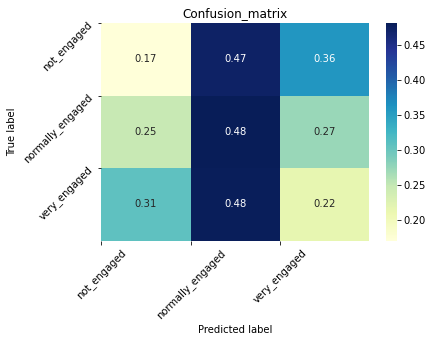

|stackedLSTM|
 Error rate = 0.690098261526833 
 MSE =  1.4610733182161753 
 Accuracy =  0.30990173847316704


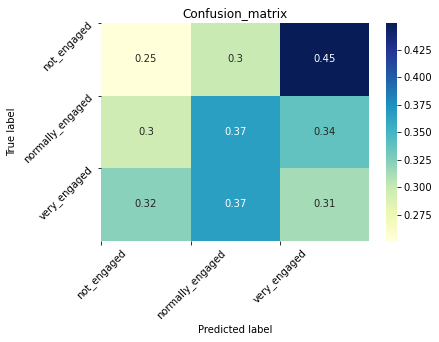

|biLSTM|
 Error rate = 0.6893424036281179 
 MSE =  1.4195011337868482 
 Accuracy =  0.31065759637188206


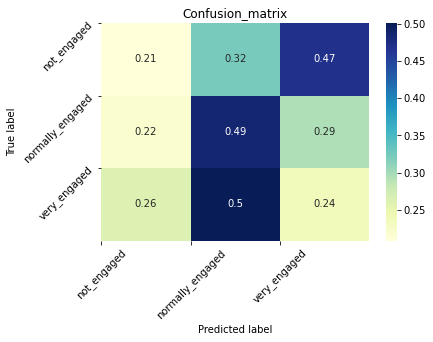

|bilstm_en|
 Error rate = 0.6681783824640968 
 MSE =  1.2690854119425548 
 Accuracy =  0.3318216175359032


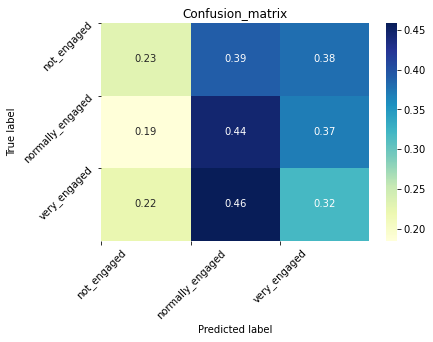

In [26]:
plot_conf_matrix(vanilaLSTM_model)
plot_conf_matrix(stackedLSTM_model)
plot_conf_matrix(biLSTM_model)
plot_conf_matrix(bilstm_en_model)

# [Case 2] Prepare non-averaged data input

In [17]:
# path = ('.../Documents/Dataset/DAiSEE/OpenFace_2.2.0_win_x64/processed/csv/')

def load_all_data(datapath,labelfile):
    #load label
    df = pd.read_csv(labelfile)
    
    #create empty list
    data_list = []
    label_list = []
    
    for noid, clipid in enumerate(df.New_ClipID):
        temp_df = pd.read_csv(datapath+clipid, nrows=300) #read csv files (n timestamps)
        # temp_df = temp_df.drop(temp_df.columns[0:5], axis=1) #drop first 5 columns 
        # temp_df = temp_df.iloc[9:300:21,:] #take 1 every 21 frame   
        temp_df = temp_df.groupby(np.arange(len(temp_df))//30).mean() #average every 30 frames, resulting 10 timesteps

        # ensure all data is float
        temp_df = temp_df.astype('float32')
              
        # PCA decomposition. Set components number from 329(original) to 200
        #     pca = decomposition.PCA(n_components=250)
        #     temp_df = pca.fit_transform(temp_df)
        #     print(temp_df)
        
        temp_df = np.array(temp_df, dtype=object)
        labl = df.Engagement[noid]
        labl = np.array(labl)
        #     print(temp_df,labl)
        data_list.append(temp_df)
        label_list.append(labl)    
#         break
    
    X = np.array(data_list, dtype=object) #features
    Y = np.array(label_list) #labels
    print('X shape:{} | Y shape:{}'.format(X.shape, Y.shape))
    
    return X, Y

In [19]:
tic = datetime.now()
X_train_all, Y_train_all = load_all_data(path+'CSV_Mediapipe/Train/',path+'labels/TrainLabels.csv')
X_val_all, Y_val_all = load_all_data(path+'CSV_Mediapipe/Validation/',path+'labels/ValidationLabels.csv')
X_test_all, Y_test_all = load_all_data(path+'CSV_Mediapipe/Test/',path+'labels/TestLabels.csv')

time = datetime.now() - tic
print('Processing time {}'.format(time))

X shape:(5467,) | Y shape:(5467,)
X shape:(1703,) | Y shape:(1703,)
X shape:(1784,) | Y shape:(1784,)
Processing time 0:18:21.817179


In [21]:
# tic = datetime.now()

# scaler = MinMaxScaler(feature_range=(0,1))
# X_train_all_scalled = scaler.fit_transform(X_train_all.reshape(-1, X_train_all.shape[-1])).reshape(X_train_all.shape)

# X_val_all_scalled = scaler.transform(X_val_all.reshape(-1, X_val_all.shape[-1])).reshape(X_val_all.shape)

# X_test_all_scalled = scaler.transform(X_test_all.reshape(-1, X_test_all.shape[-1])).reshape(X_test_all.shape)

# time = datetime.now() - tic
# print('Processing time {}'.format(time))
# print(X_train_all_scalled.shape,X_val_all_scalled.shape,X_test_all_scalled.shape)

In [ ]:
# tic = datetime.now()

# pca = decomposition.PCA(n_components=250)
# X_train_all_scalled = pca.fit_transform(X_train_all_scalled.reshape(-1, X_train_all_scalled.shape[-1])).reshape(X_train_all_scalled.shape)

# X_val_all_scalled = pca.transform(X_val_all_scalled.reshape(-1, X_val_all_scalled.shape[-1])).reshape(X_val_all_scalled.shape)

# X_test_all_scalled = pca.transform(X_test_all_scalled.reshape(-1, X_test_all_scalled.shape[-1])).reshape(X_test_all_scalled.shape)

# time = datetime.now() - tic
# print('Processing time {}'.format(time))

In [22]:
# Export dataset in pickle format
# with open('.../Documents/Exp_Shofi/Statistical Analysis/extracted/daisee_329dims_10timesteps.pkl','wb') as f:
with open(path+'daisee_329dims_10timesteps.pkl','wb') as f:
    pickle.dump([X_train_all, X_val_all, X_test_all, Y_train_all, Y_val_all, Y_test_all], f)
    # pickle.dump([X_train_all, X_val_all, X_test_all, X_train_all_scalled, X_val_all_scalled, X_test_all_scalled, Y_train_all, Y_val_all, Y_test_all], f)